In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from channel import SSFChannel, Splitter, PolarizationRotation, DropPolarization
from filters import CDCompensator, Decimate, PulseFilter, AdaptiveEqualizerAlamouti
from modulation import DemodulatorDQPSK, DemodulatorQPSK, ModulatorQPSK, AlamoutiEncoder, DPModulator
from receiver import NoisyOpticalFrontEnd
from laser import NoisyLaser, ContinuousWaveLaser

In [3]:
CHANNEL_SPS = 16
RECEIVER_SPS = 2
# At Eb/N0 = 10 dB, we need around 49 taps at 25 km, 79 taps at 50 km, and 143
# taps at 100 km. However, we can go up to 2**n - 1 without increasing the
# overlap-save frame size, which should be strictly better.
CDC_TAPS = 63
FIBRE_LENGTH = 25_000  # 25 km
SPLITTING_POINT = 24_000  # 24 km
CONSUMERS = 16 # XXX
SYMBOL_RATE = 10 * 10**9  # 10 GS/s XXX
TARGET_BER = 0.5 * 10**-3
DDPR_BUFFER_SIZE = 64
LASER_LINEWIDTH_ESTIMATE = 100e3  # 100 kHz
SNR_ESTIMATE = 10  # 10 dB
# Paper uses 60,000 QPSK training symbols
LENGTH = 2**18 #  256 Ki

In [4]:
def plot_signal(signal: np.ndarray) -> None:
    assert signal.ndim == 1
    assert signal.size > 0

    s_real = np.real(signal[:10000])
    s_imag = np.imag(signal[:10000])

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

    # Constellation diagram.
    ax = axs[0][0]
    ax.scatter(s_real, s_imag, alpha=0.05)
    ax.axis("equal")
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(color="black")
    ax.axvline(color="black")

    # Unused plot.
    axs[1][0].set_axis_off()

    # Signal (real component).
    ax = axs[0][1]
    ax.stem(s_real)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("In-phase")

    # Signal (imaginary component).
    ax = axs[1][1]
    ax.stem(s_imag)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("Quadrature")

    # Spectrum.
    axs[0][2].magnitude_spectrum(signal.tolist(), sides="twosided")
    axs[1][2].phase_spectrum(signal.tolist(), sides="twosided")

    fig.tight_layout()

    plt.show()

In [5]:
data = np.random.randint(0, 2, LENGTH * 2, np.bool_)

tx_mod = ModulatorQPSK()(data)

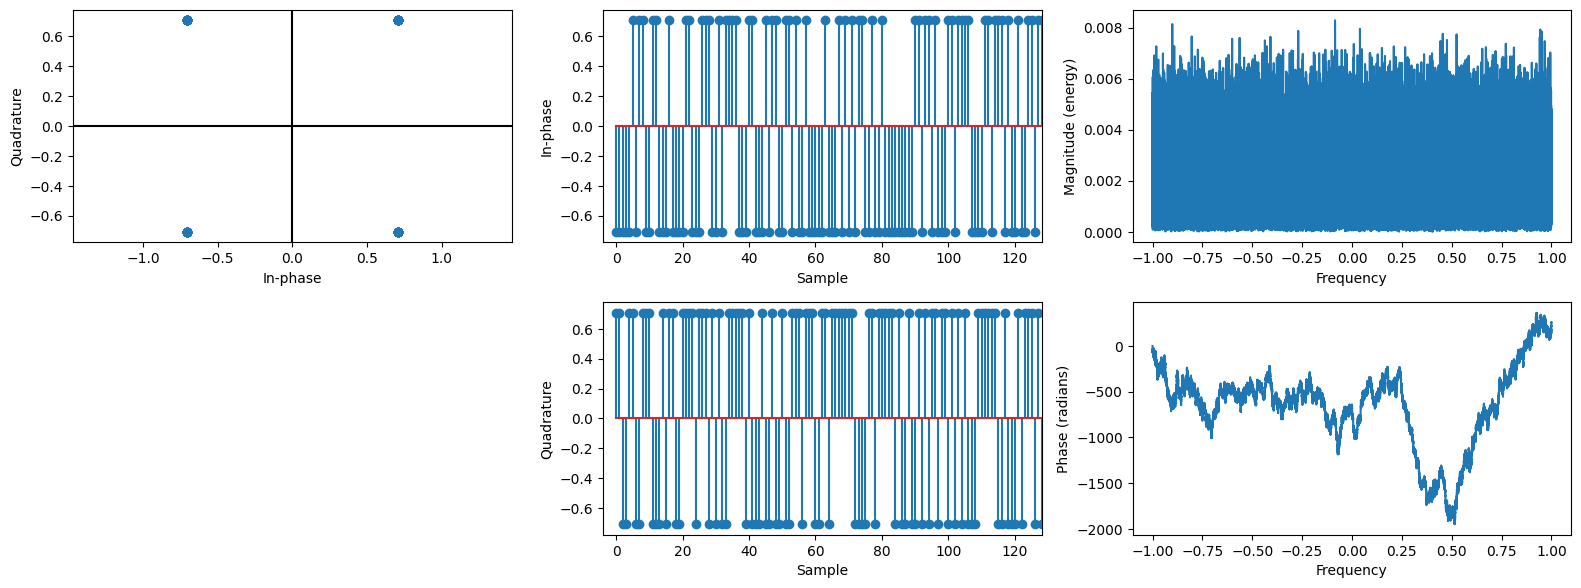

In [6]:
plot_signal(tx_mod)

In [7]:
# Alamouti encoding. 2 polarizations.
tx_alamouti = AlamoutiEncoder()(tx_mod)

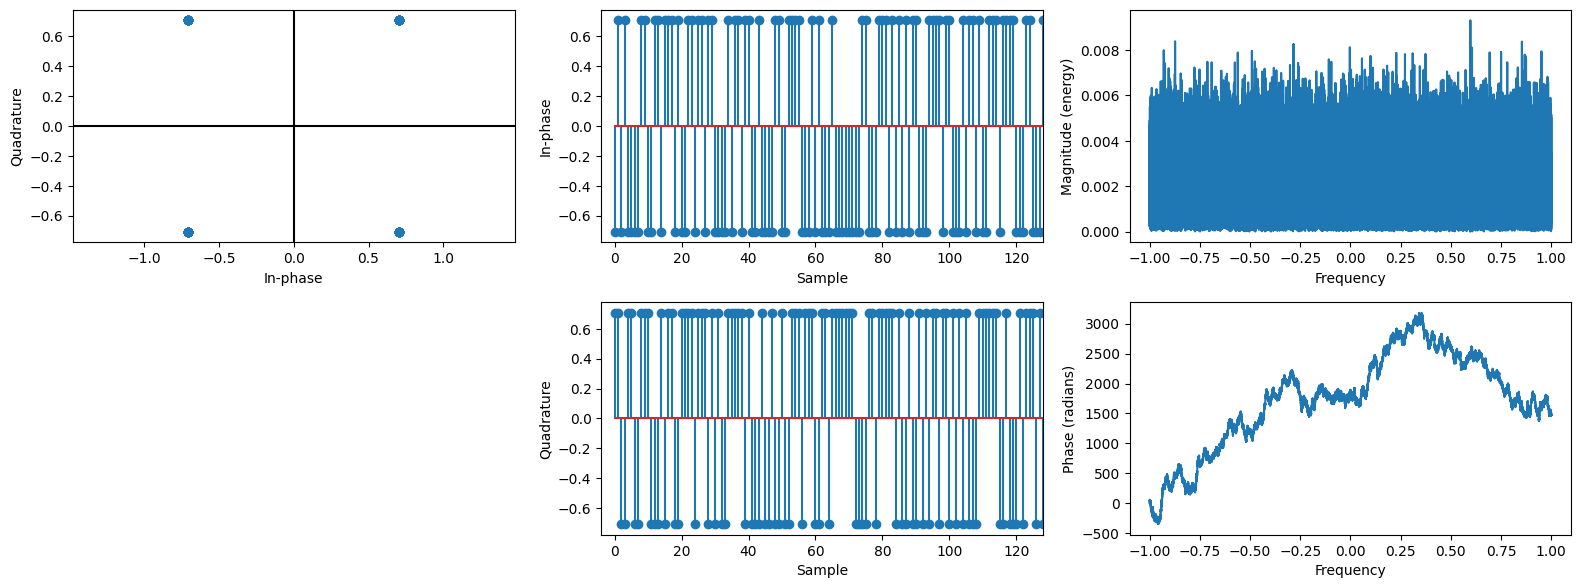

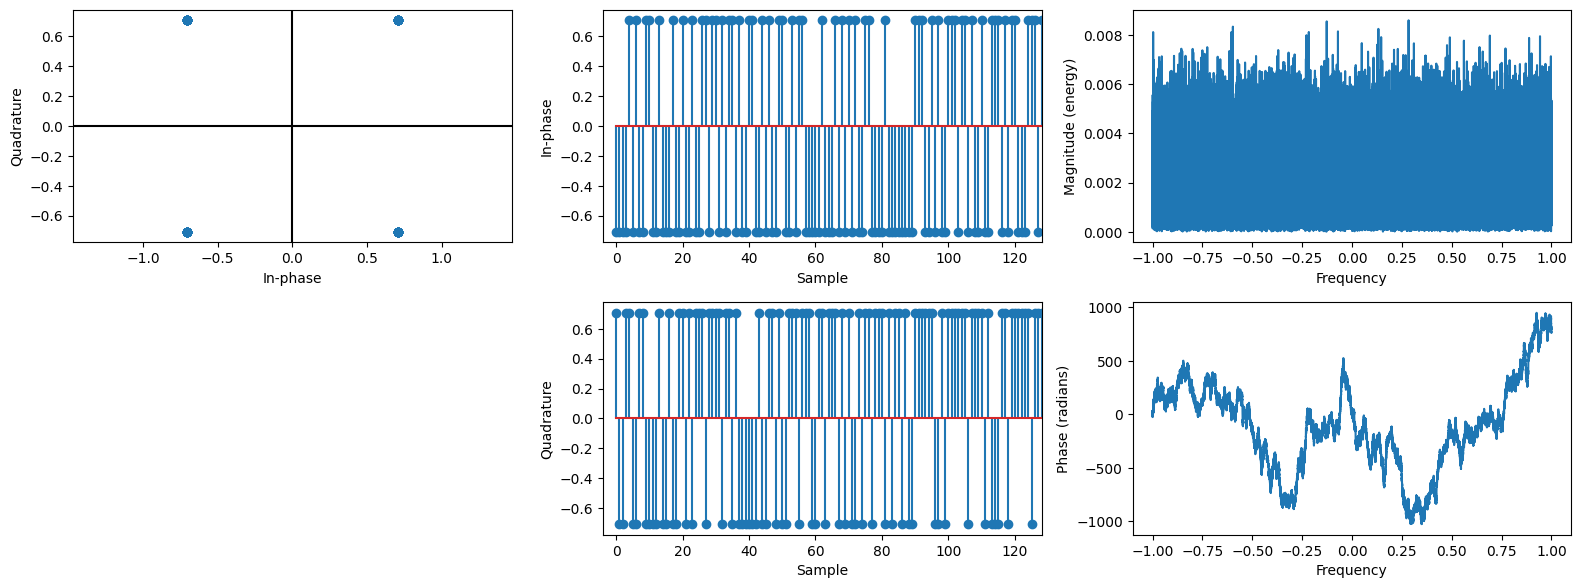

In [8]:
plot_signal(tx_alamouti[0])
plot_signal(tx_alamouti[1])

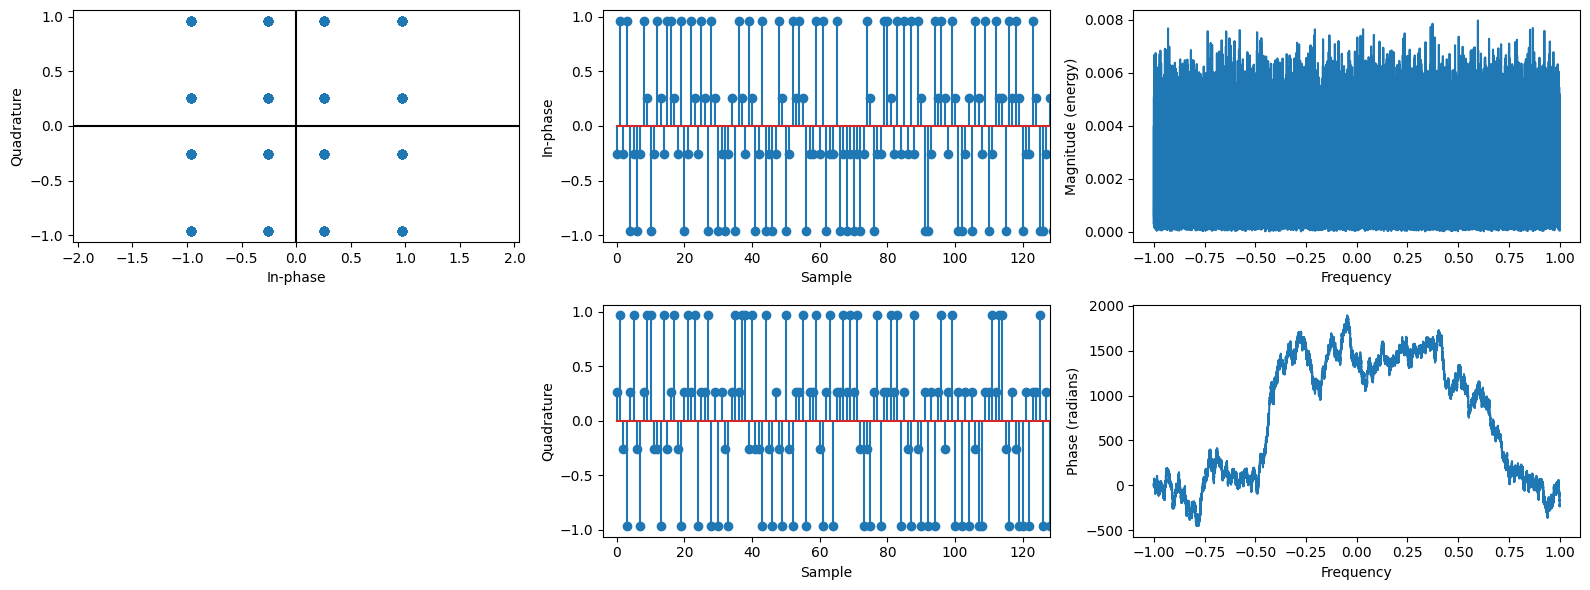

In [9]:
# XXX we get 16 symbols after the polarizations mix together.
plot_signal(PolarizationRotation(np.pi/6)(tx_alamouti)[0])

In [10]:
tx_pf = PulseFilter(CHANNEL_SPS, up=CHANNEL_SPS)(tx_alamouti)

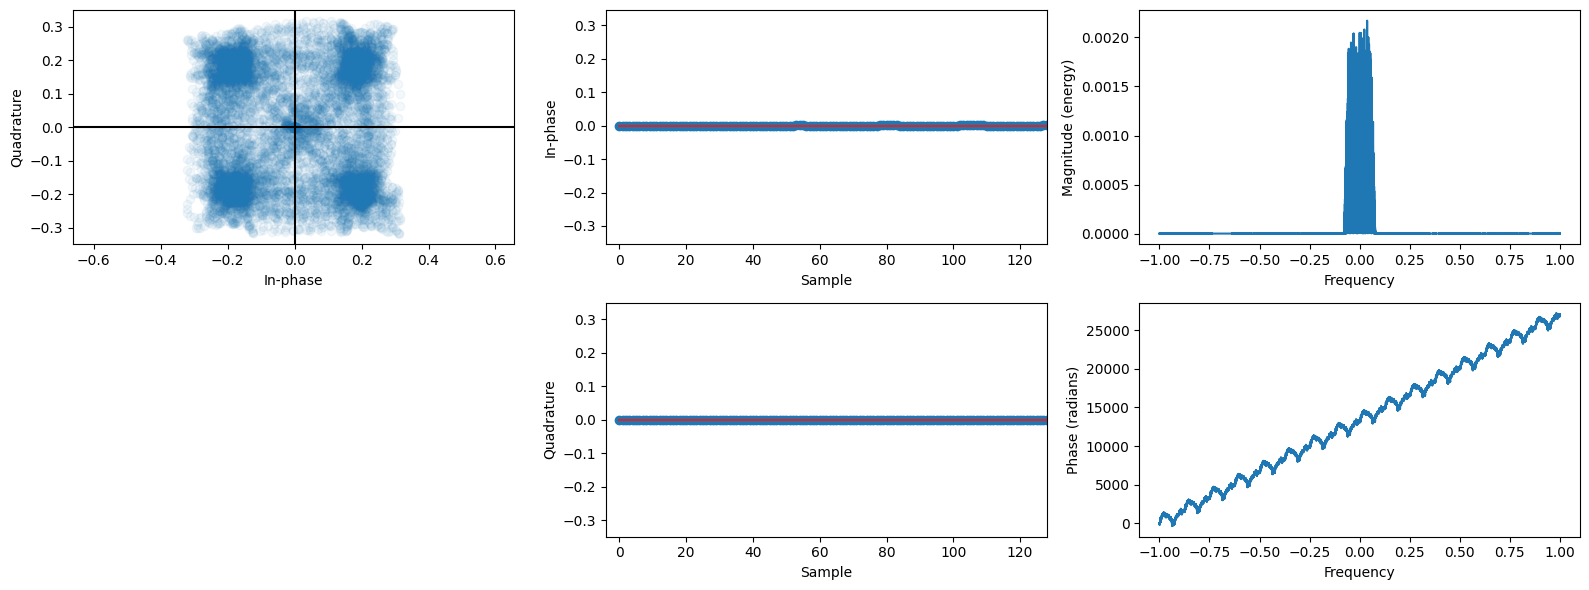

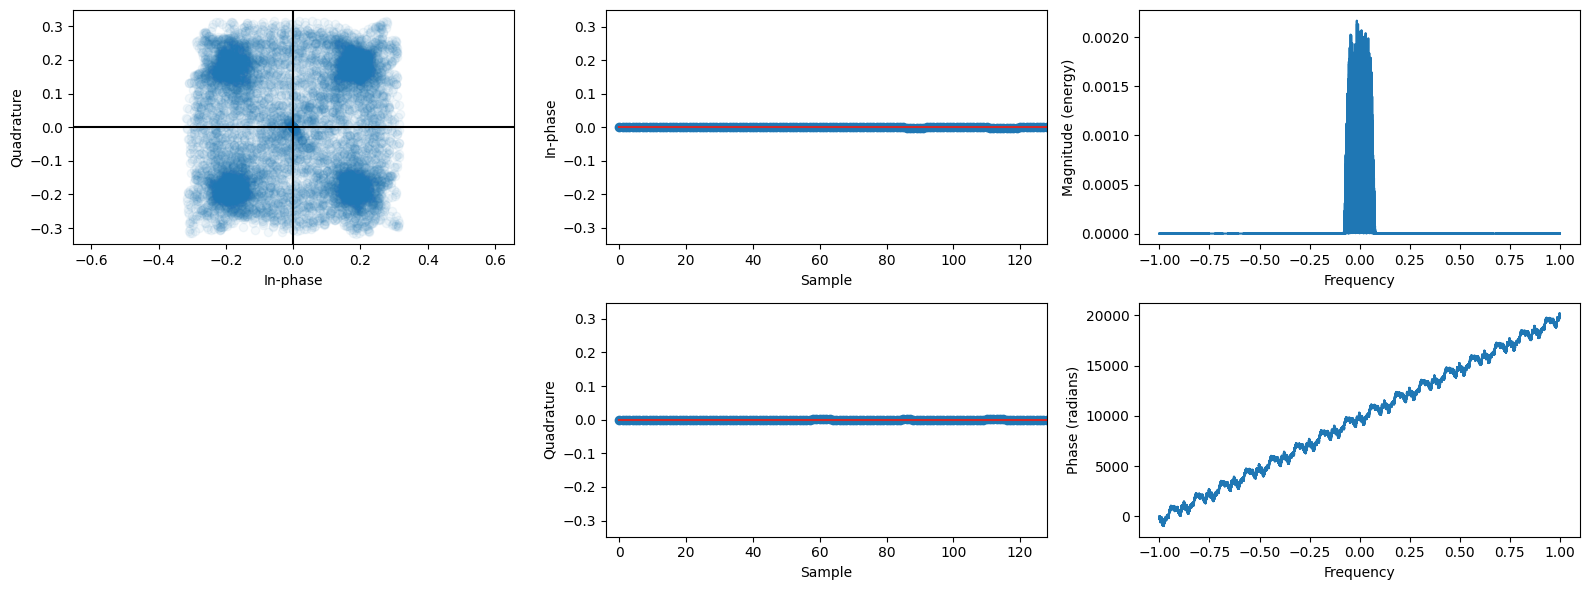

In [11]:
plot_signal(tx_pf[0])
plot_signal(tx_pf[1])

In [12]:
laser = NoisyLaser(0, SYMBOL_RATE * CHANNEL_SPS)
tx_txd = DPModulator(laser)(tx_pf)
# tx_txd = DPModulator(ContinuousWaveLaser(0))(tx_pf)

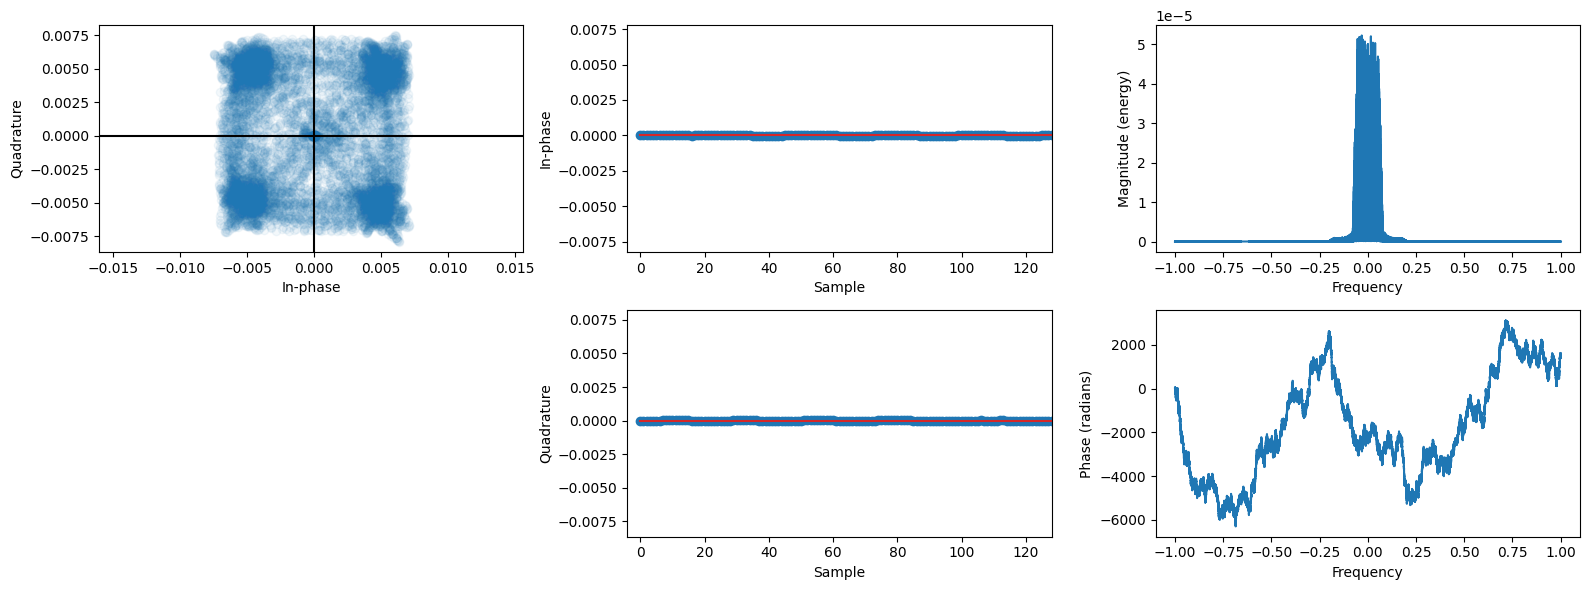

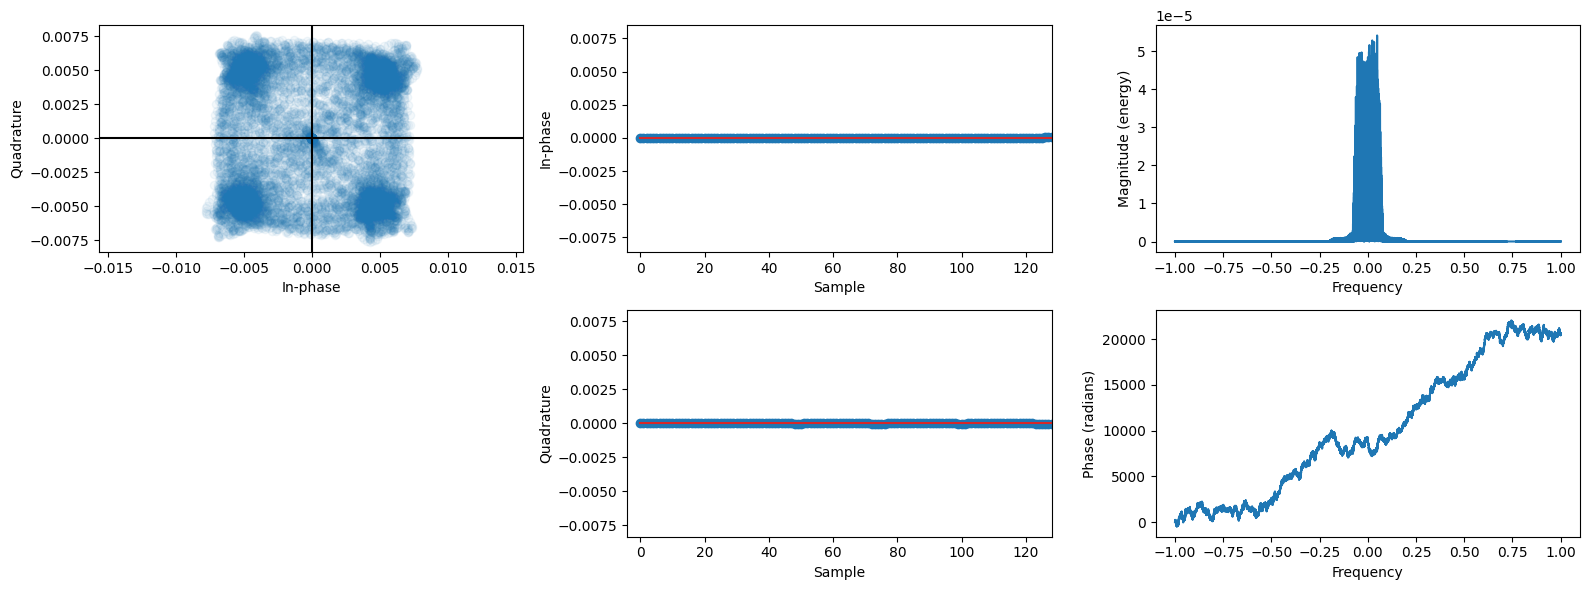

In [13]:
plot_signal(tx_txd[0])
plot_signal(tx_txd[1])

In [14]:
ch_1 = SSFChannel(SPLITTING_POINT, SYMBOL_RATE * CHANNEL_SPS)(tx_txd)
ch_s = Splitter(CONSUMERS)(ch_1)
ch_2 = SSFChannel(FIBRE_LENGTH - SPLITTING_POINT, SYMBOL_RATE * CHANNEL_SPS)(ch_s)

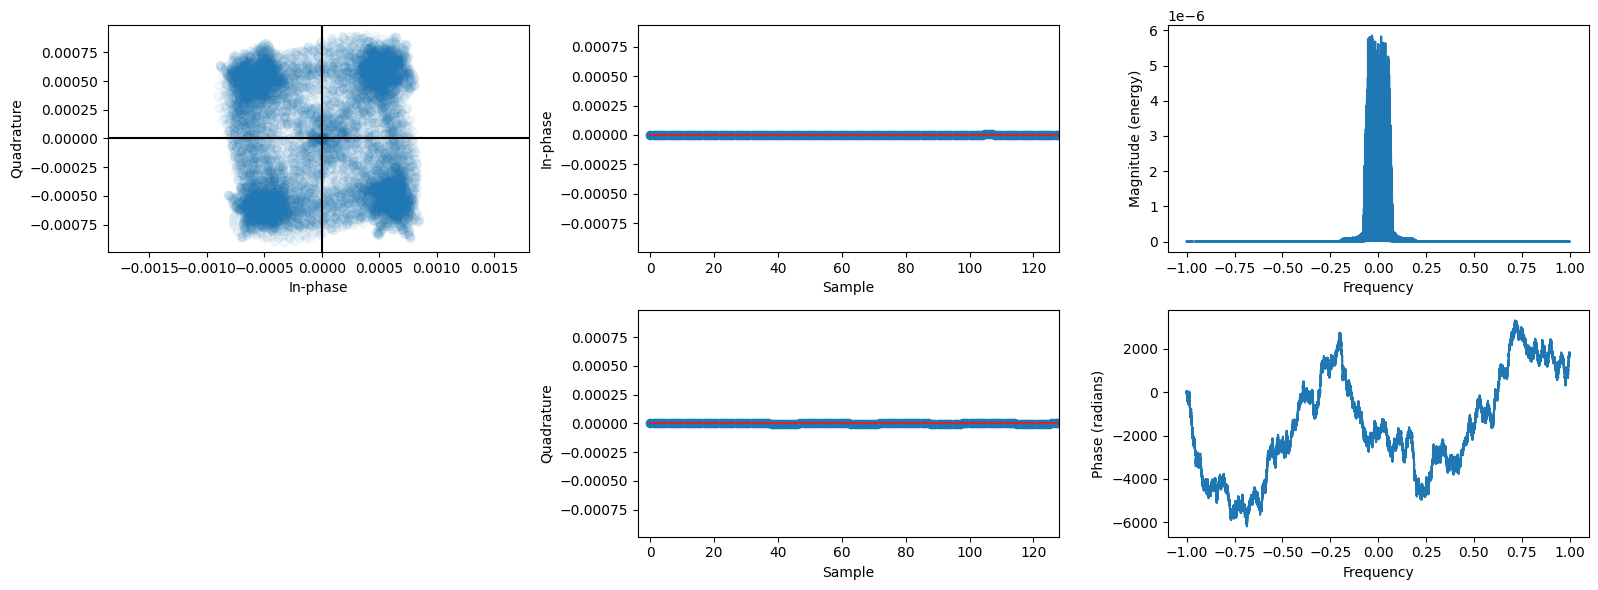

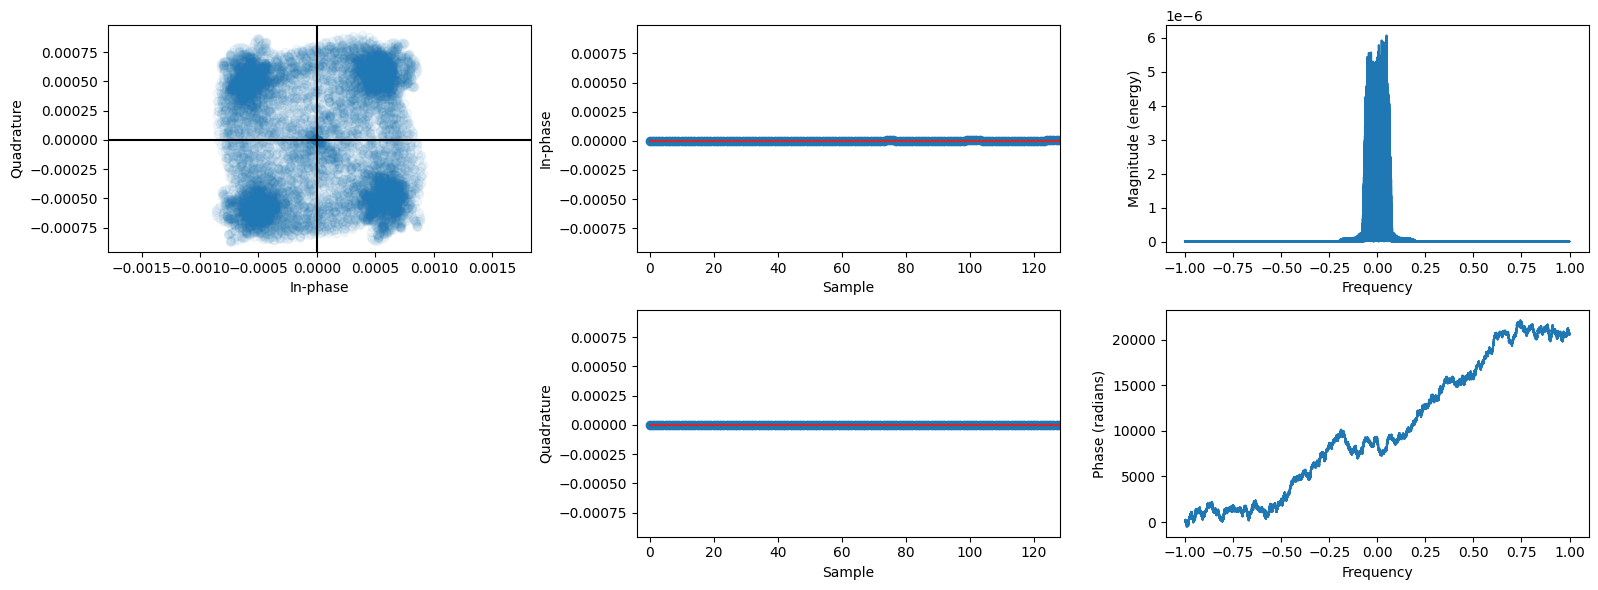

In [15]:
plot_signal(ch_2[0])
plot_signal(ch_2[1])

In [16]:
ch_rot = PolarizationRotation(np.pi/3)(ch_2)
ch_one = DropPolarization()(ch_rot)

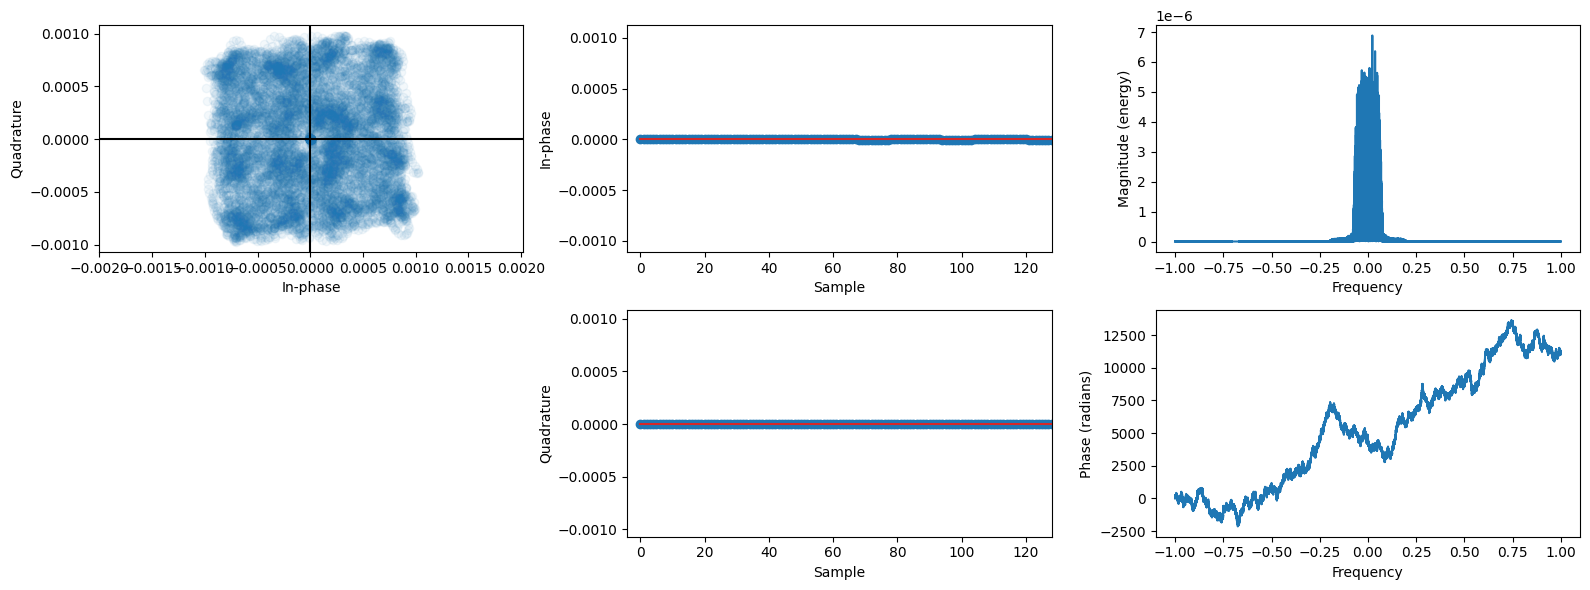

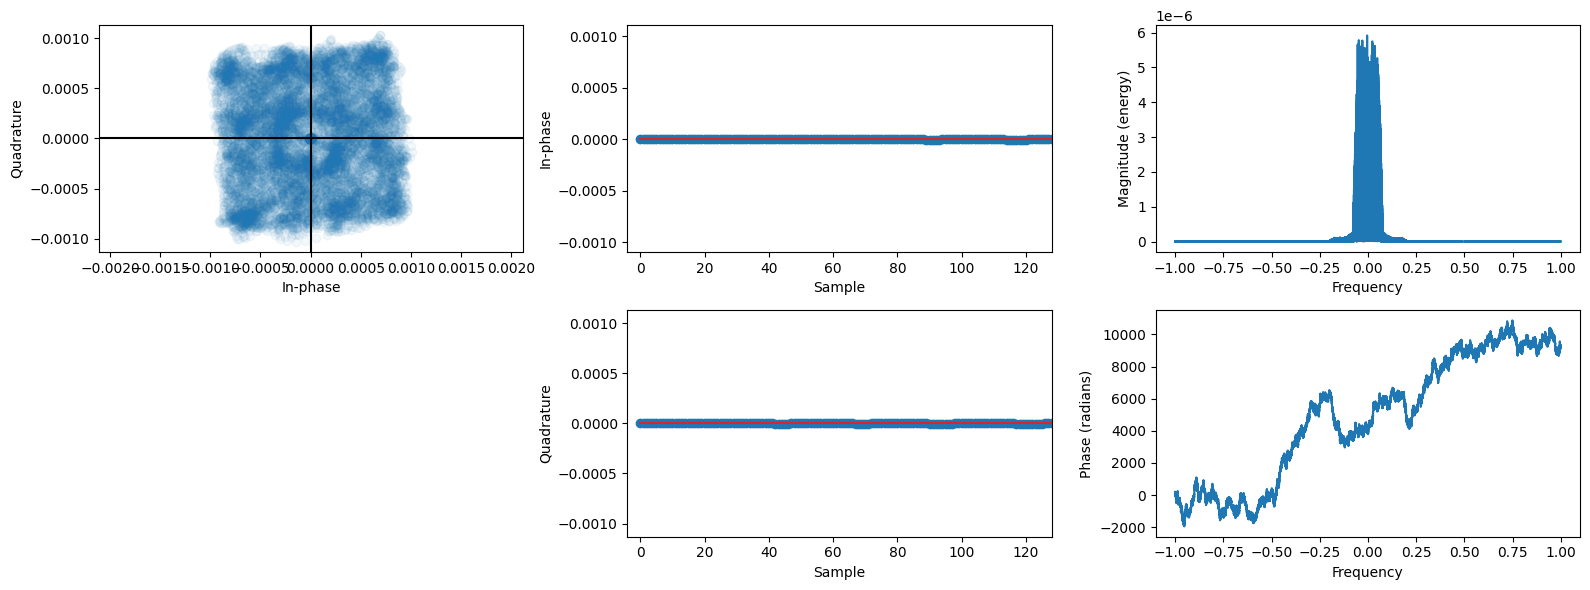

In [17]:
plot_signal(ch_rot[0])
plot_signal(ch_rot[1])

In [18]:
rx_fe = NoisyOpticalFrontEnd(SYMBOL_RATE * CHANNEL_SPS)(ch_one)

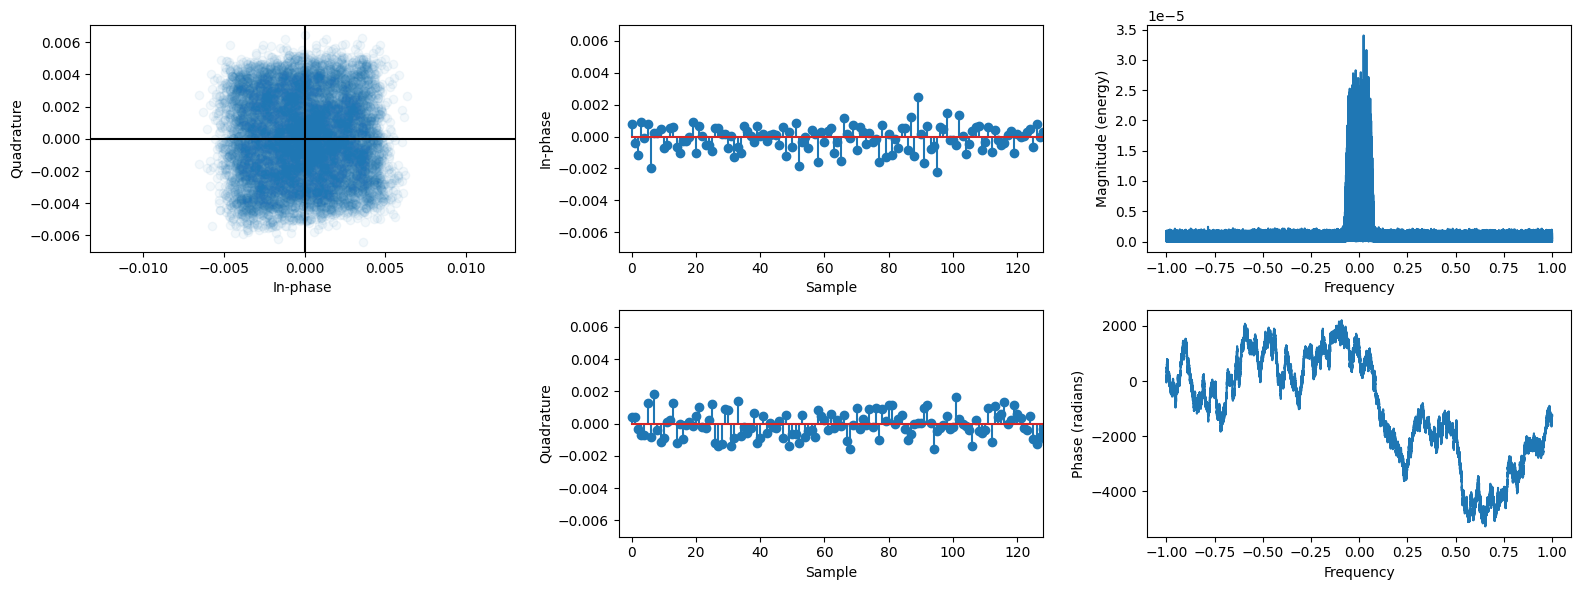

In [19]:
plot_signal(rx_fe)

In [20]:
rx_down = Decimate(CHANNEL_SPS // RECEIVER_SPS)(rx_fe)

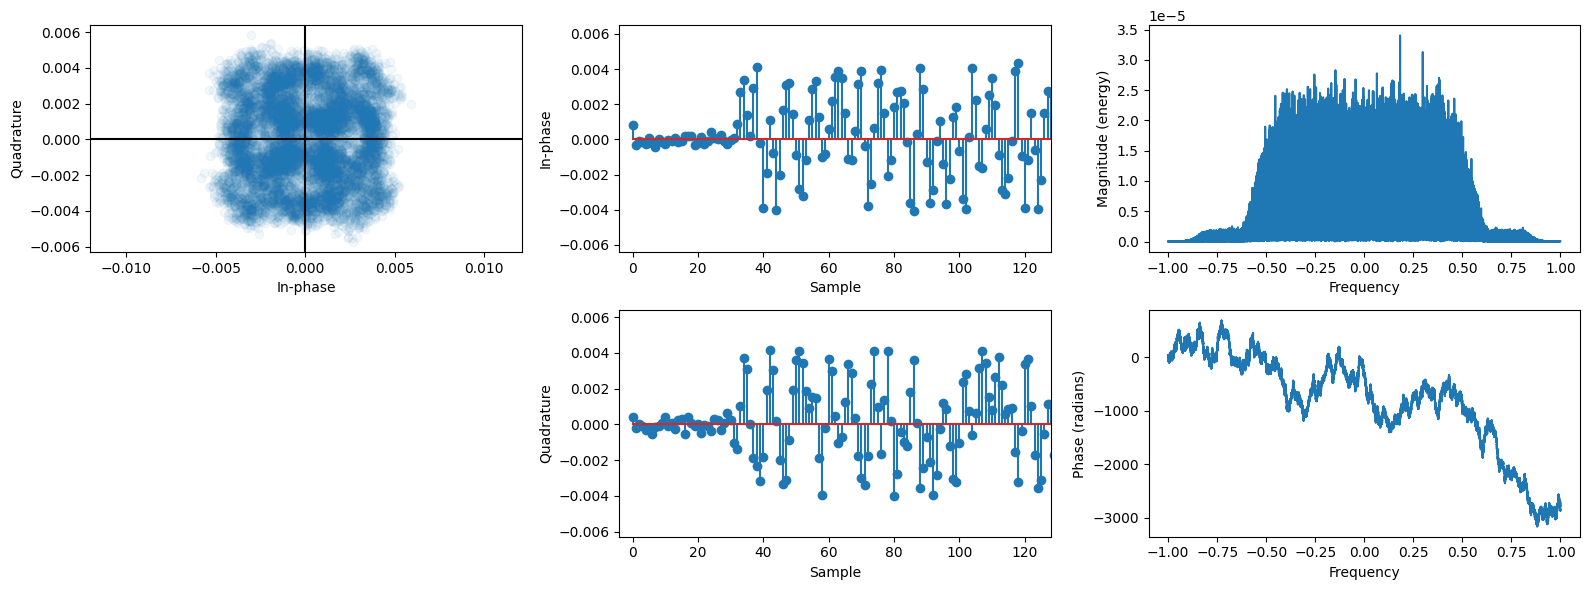

In [21]:
plot_signal(rx_down)

In [22]:
rx_cdc = CDCompensator(FIBRE_LENGTH, SYMBOL_RATE * RECEIVER_SPS, RECEIVER_SPS, CDC_TAPS)(rx_down)

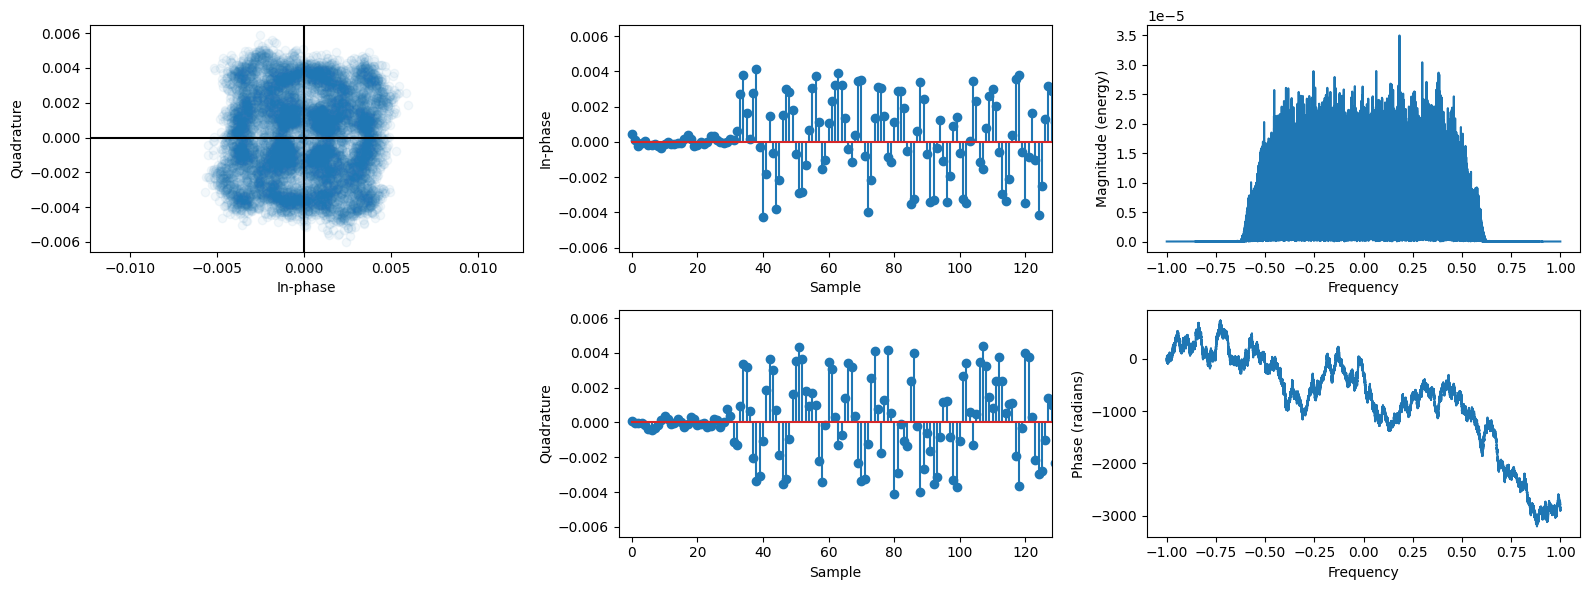

In [23]:
plot_signal(rx_cdc)

In [24]:
rx_pf = np.pad(PulseFilter(RECEIVER_SPS, down=1)(rx_cdc), (0, 1))

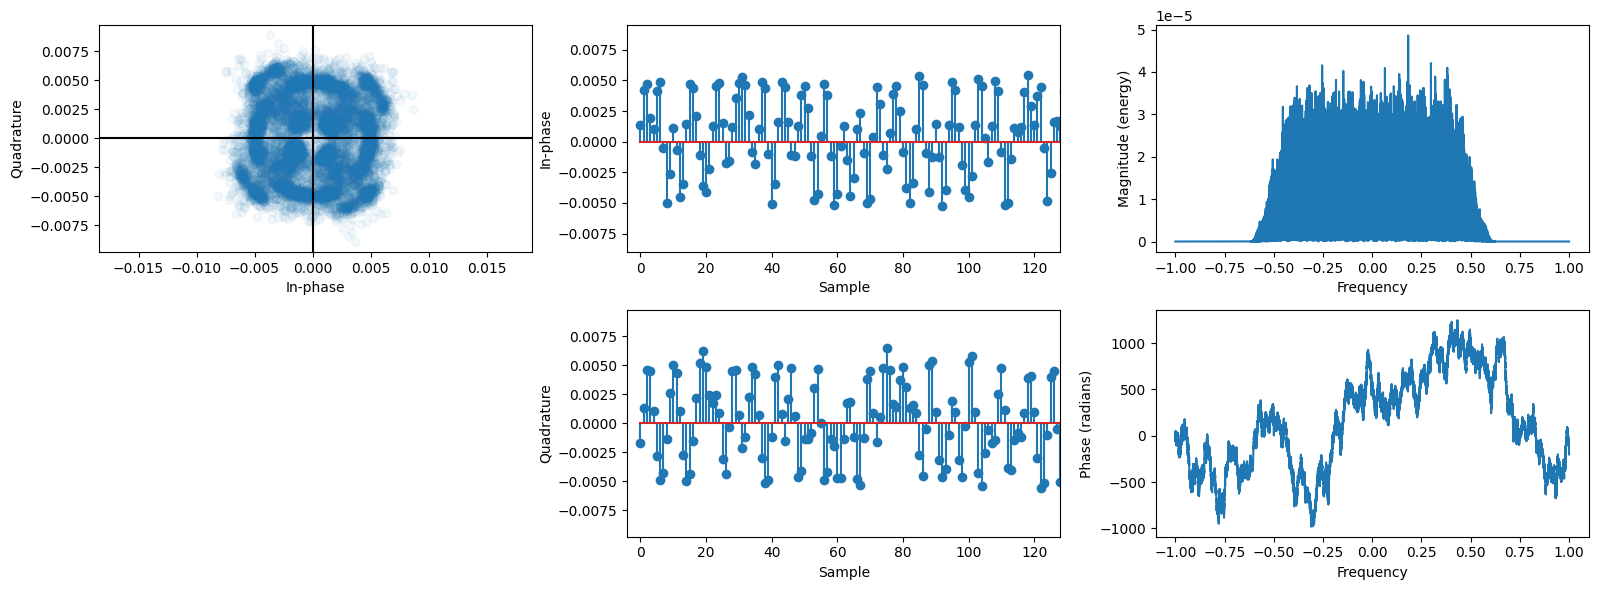

In [25]:
plot_signal(rx_pf)

In [72]:
aeq = AdaptiveEqualizerAlamouti(17, 1e-5, 1e-2, ModulatorQPSK(), DemodulatorQPSK(), tx_mod)
rx_aeq = aeq(rx_pf)
for _ in range(3):
    aeq.p_1 = 1
    aeq.p_2 = 1
    rx_aeq = aeq(rx_pf)

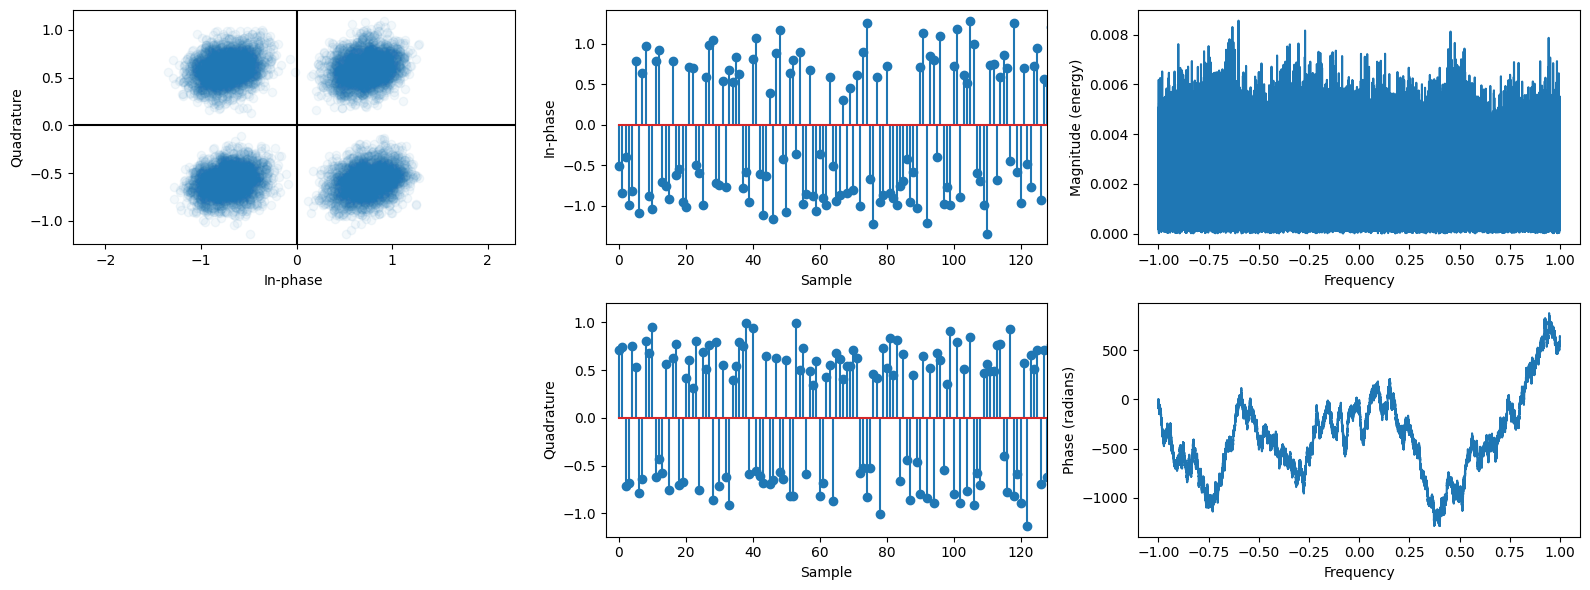

In [73]:
plot_signal(rx_aeq)

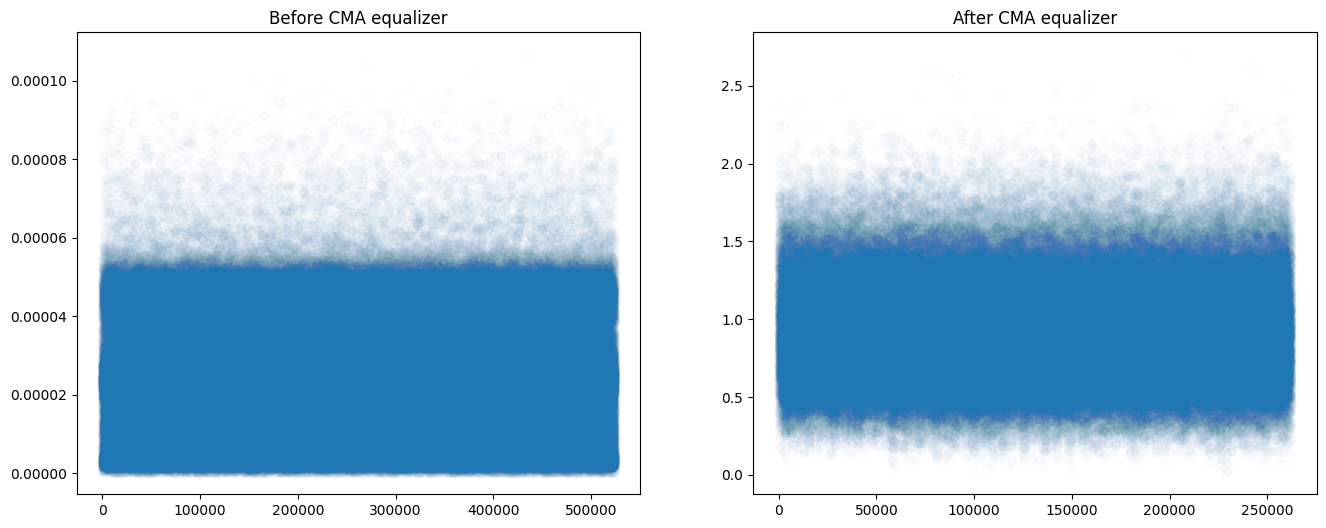

In [74]:
from utils import samples_squared

fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(range(rx_pf.size), samples_squared(rx_pf), alpha=0.01)
axs[0].set_title("Before CMA equalizer")
axs[1].scatter(range(rx_aeq.size), samples_squared(rx_aeq), alpha=0.01)
axs[1].set_title("After CMA equalizer")
plt.show()

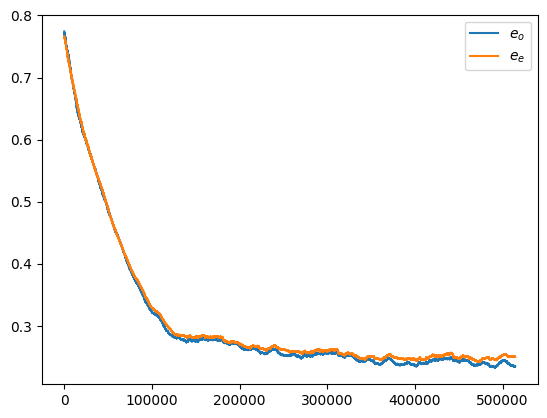

In [75]:
def ma(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(ma(np.abs(aeq.e_o_log), 10_000), label="$e_o$")
plt.plot(ma(np.abs(aeq.e_e_log), 10_000), label="$e_e$")
plt.legend()
plt.show()

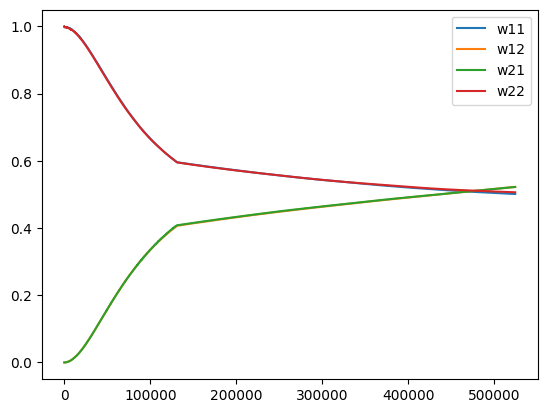

In [76]:
plt.plot(range(len(aeq.w11_log)), aeq.w11_log, label="w11")
plt.plot(range(len(aeq.w11_log)), aeq.w12_log, label="w12")
plt.plot(range(len(aeq.w11_log)), aeq.w21_log, label="w21")
plt.plot(range(len(aeq.w11_log)), aeq.w22_log, label="w22")
plt.legend()
plt.show()

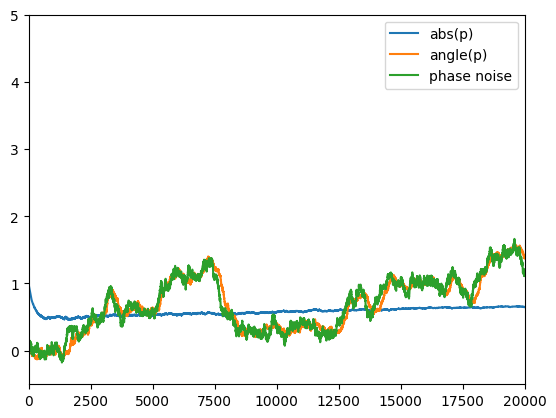

In [77]:
plt.plot(np.abs(aeq.p_log), label="abs(p)")
plt.plot(np.unwrap(np.angle(aeq.p_log)), label="angle(p)")
plt.plot(-np.unwrap(laser.last_noise[::32]), label="phase noise")
plt.legend()
plt.xlim(0,20_000)
plt.ylim(-0.5, 5)
plt.show()

In [78]:
print(np.mean(aeq.e_o_log))
print(np.mean(aeq.e_e_log))

(-0.0009591408666938114+0.00035247153677068837j)
(0.0011584172508556972+0.0011118858953096478j)


In [79]:
rx_demod = DemodulatorQPSK()(rx_aeq)

In [80]:
def print_ber(a, b) -> None:
    assert a.shape == b.shape
    print(np.count_nonzero(a ^ b) / a.size)

In [81]:
print_ber(rx_demod, data)

3.814697265625e-05


In [82]:
rx_ddemod = DemodulatorDQPSK()(rx_aeq)[1:]
ref_ddemod = DemodulatorDQPSK()(tx_mod)[1:]

print_ber(rx_ddemod, ref_ddemod)

0.0001201631930602895


In [83]:
import scipy.signal
from numpy.typing import NDArray

def find_lag(ref: NDArray[np.bool_], sig: NDArray[np.bool_]) -> int:
    corr = scipy.signal.correlate(ref.astype(np.float64), sig.astype(np.float64))
    lags = scipy.signal.correlation_lags(ref.size, sig.size)

    lag = lags[np.argmax(corr)]

    return lag


def compare_streams(
    ref: NDArray[np.bool_], sig: NDArray[np.bool_]
) -> tuple[float, float]:
    # Ensure lag + y.size < x.size.
    sig_slice = sig[:-10_000] if sig.size > ref.size - 10_000 else sig

    # Both polarizations carry the same data, but one stream is delayed by 98
    # symbols (196 bits). Unfortunately, this isn't always the case.
    lag = find_lag(ref, sig_slice)
    assert lag >= 0

    ref_slice = ref[lag : lag + sig_slice.size]
    assert ref_slice.size == sig_slice.size

    ber = np.count_nonzero(ref_slice ^ sig_slice) / ref_slice.size

    return lag, ber

In [84]:
compare_streams(rx_ddemod, ref_ddemod)

(0, 0.00012249969375076564)

In [85]:
# compare_streams(rx_demod, data)
compare_streams(data, rx_demod)

(0, 3.8888716050150886e-05)